In [1]:
import os
import pandas as pd
from datetime import datetime

def phase_wise_analysis(df, corr_col, ramp_col, coil_length_col, threshold=0.7, window_size=250):
    if df[ramp_col].max() <= 15:
        return []

    norm_val = df[ramp_col].mode()[0]
    norm_df = df[df[ramp_col] == norm_val]
    if norm_df.empty:
        return []

    phase1_end = norm_df.index[0]
    phase2_end = norm_df.index[-1]

    # Define dataframes for each phase
    phase1_df = df.iloc[:phase1_end + 1]
    phase2_df = df.iloc[phase1_end:phase2_end + 1]
    phase3_df = df.iloc[phase2_end + 1:]

    results = []
    for phase_df, phase_name in zip([phase1_df, phase2_df, phase3_df], ['Phase 1', 'Phase 2', 'Phase 3']):
        corr_series = phase_df[corr_col].iloc[window_size - 1:].dropna()
        total = len(corr_series)
        significant = (corr_series.abs() >= threshold).sum()
        contribution = (significant / total) if total > 0 else 0
        avg_corr = corr_series[abs(corr_series) >= threshold].abs().mean() if significant > 0 else 0

        results.append((phase_name, total, significant, contribution, avg_corr))
    return results

def run_phasewise_analysis_from_pickle_excel(excel_file_path, base_folder, signal_features, shape_feature_map, coil_length_col, ramp_col='Master Ramp', threshold=0.7, window_size=250):
    xls = pd.ExcelFile(excel_file_path)
    all_results = []

    for sheet_name, shape_feature in shape_feature_map.items():
        count=0
        if sheet_name not in xls.sheet_names:
            print(f"Sheet '{sheet_name}' not found. Skipping.")
            continue

        try:
            df_ids = pd.read_excel(xls, sheet_name=sheet_name)
            if 'Pickle ID' not in df_ids.columns:
                print(f"No 'Pickle ID' column in sheet {sheet_name}. Skipping.")
                continue
            valid_ids = set(str(x).strip() for x in df_ids['Pickle ID'].dropna().unique())
        except Exception as e:
            print(f"Error reading sheet '{sheet_name}': {e}")
            continue

        print(f"\nSheet: {sheet_name} | Shape Feature: {shape_feature} | Total Pickle IDs: {len(valid_ids)}")

        for pickle_id in valid_ids:
            file_name = f"{pickle_id}.csv"
            file_path = os.path.join(base_folder, file_name)
            if not os.path.exists(file_path):
                print(f"File not found for Pickle ID: {pickle_id}")
                count+=1
                continue

            try:
                df = pd.read_csv(file_path)
            except Exception as e:
                print(f"Error reading file {file_name}: {e}")
                continue

            for signal in signal_features:
                corr_col = f"{signal}_Rolling_Corr_{shape_feature}"
                if corr_col not in df.columns:
                    continue

                phase_stats = phase_wise_analysis(df, corr_col, ramp_col, coil_length_col, threshold, window_size)
                for phase_name, total, significant, contribution, avg_corr in phase_stats:
                    all_results.append({
                        "Pickle ID": pickle_id,
                        "Sheet": sheet_name,
                        "Phase": phase_name,
                        "Signal Feature": signal,
                        "Shape Feature": shape_feature,
                        "Total Windows": total,
                        "Significant Correlation Window Count": significant,
                        "Contribution Factor %": f"{contribution * 100:.4f}",
                        "Average Correlation": avg_corr
                    })
        print(f"{count} coils are missing in {sheet_name}")
    final_df = pd.DataFrame(all_results)
    final_df["Contribution Factor %"] = final_df["Contribution Factor %"].astype(float)
    final_df = final_df[final_df["Contribution Factor %"] > 5]
    final_df.to_csv(r"D:\Stelco\Work\Dynamic Correlation\Key\Phasewise_summary_from_pickle_ids.csv", index=False)
    print("\nDone! Saved to 'Phasewise_summary_from_pickle_ids.csv'")


# def process_file_phase_wise(file_path, signal_features, shape_features, coil_length_col, ramp_col='Master Ramp', threshold=0.7, window_size=250):
#     df = pd.read_csv(file_path)
#     coil_id = df['Coil ID'].iloc[0]
#     # folder_name = os.path.basename(os.path.dirname(os.path.dirname(file_path)))  # Get parent folder name
#     # coil_type, grade = folder_name.split(" ")

#     all_results = []

#     for signal in signal_features:
#         for shape in shape_features:
#             corr_col = f"{signal}_Rolling_Corr_{shape}"
#             if corr_col not in df.columns:
#                 print(f"{corr_col} not in file")
#                 continue

#             phase_stats = phase_wise_analysis(df, corr_col, ramp_col, coil_length_col, threshold, window_size)
#             for phase_name, total, significant, contribution, avg_corr in phase_stats:
#                 all_results.append({
#                     "Coil ID": coil_id,
#                     "Phase": phase_name,
#                     # "Coil Type": coil_type,
#                     # "Grade": grade,
#                     "Signal Feature": signal,
#                     "Shape Feature": shape,
#                     "Total Windows": total,
#                     "Significant Correlation Window Count": significant,
#                     "Contribution Factor %": f"{contribution * 100:.4f}",
#                     "Average Correlation": avg_corr
#                 })

#     return all_results


# def process_folders_phasewise(base_folders, signal_features, shape_features, coil_length_col, ramp_col='Master Ramp', threshold=0.7, window_size=250):
#     all_results = []

#     for folder in base_folders:
#         print(folder)
#         files = [f for f in os.listdir(folder) if f.endswith(".csv")]
#         print(f"\nProcessing folder: {folder} | Files: {len(files)}")
#         start_time = datetime.now()

#         for file in files:
#             print(file)
#             file_path = os.path.join(folder, file)
#             results = process_file_phase_wise(file_path, signal_features, shape_features, coil_length_col, ramp_col, threshold, window_size)
#             all_results.extend(results)

#         print(f"Finished folder: {folder} | Time taken: {datetime.now() - start_time}")
        
#     final_df = pd.DataFrame(all_results)
#     final_df["Contribution Factor %"] = final_df["Contribution Factor %"].astype(float)
#     final_df = final_df[final_df["Contribution Factor %"] > 5]

    
#     # final_output = "Phasewise_correlation_summary_1008GCQ_Good_Rework_Divert_Stand4Signals.csv"
#     final_output = "Phasewise_correlation_summary.csv"
#     final_df.to_csv(final_output, index=False)
#     print(f"\n All folders processed. Final summary saved to: {final_output}")


# === INPUT PARAMETERS ===

coil_types = r"D:\Stelco\Work\Dynamic Correlation\Key\Master Whole Phase 1"

signal_features = ['X4 Gauge Deviation',
              'Master Ramp', 'Stand 1 Gap Operator Offset', 'Stand 2 Gap Operator Offset',
                 'Stand 3 Gap Operator Offset', 'Stand 4 Gap Operator Offset', 'S1 Operating Bending Trim', 'S2 Operating Bending Trim',
                 'S3 Operating Bending Trim', 'S4 Operating Bending Trim',
               'X0 Gauge Deviation', 'X1 Gauge Deviation',
               'Stand 1-2 Tension Reference', 'Stand 2-3 Tension Reference', 'Stand 3-4 Tension Reference', 'Stand 1-2 Total Tension Feedback',
                 'Stand 2-3 Total Tension Feedback', 'Stand 3-4 Total Tension Feedback', 'Exit Tension Reel Tension Reference',
                 'Tension Reel Calculated Tension', 'Stand 1 Gap Bite Offset', 'Stand 1 Gap Stick Offset', 'Stand 1 Gap Thread Offset',
                 'Stand 1 Thread Gap Setpoint', 'Stand 1 Run Gap Setpoint', 'Stand 2 Gap Bite Offset', 'Stand 2 Gap Stick Offset',
                 'Stand 2 Gap Thread Offset', 'Stand 2 Thread Gap Setpoint', 'Stand 2 Run Gap Setpoint', 'Stand 3 Gap Bite Offset',
                 'Stand 3 Gap Stick Offset', 'Stand 3 Gap Thread Offset', 'Stand 3 Thread Gap Setpoint', 'Stand 3 Run Gap Setpoint',
                 'Stand 4 Gap Bite Offset', 'Stand 4 Gap Stick Offset', 'Stand 4 Gap Thread Offset', 'Stand 4 Thread Gap Setpoint',
                 'Stand 4 Run Gap Setpoint', 'Stand 1 Predicted Run Force', 'Stand 2 Predicted Run Force', 'Stand 3 Predicted Run Force',
                 'Stand 4 Predicted Run Force', 'Stand 1 - Total Force', 'Stand 2 - Total Force', 'Stand 2 - Total Force', 'Stand 2 - Total Force',
                 'Stand 1 Top Current Feedback', 'Stand 2 Top Current Feedback', 'Stand 3 Top Current Feedback', 'Stand 4 Top Current Feedback',
                 'Stand 1 Bottom Current Feedback', 'Stand 2 Bottom Current Feedback', 'Stand 3 Bottom Current Feedback', 'Stand 4 Bottom Current Feedback',
                 'Master Ramp', 'AGC GE Feedforward Hardness Number', 'AGC Alex Dynamic Feedforward Hardness Number', 'Stand 1 Total Bending Feedback',
                 'Stand 2 Total Bending Feedback', 'Stand 3 Total Bending Feedback', 'Stand 4 OS Total Bending Feedback', 'Stand 4 DS Total Bending Feedback', 'Stand 1 - Operator Side Force', 
                 'Stand 1 - Drive Side Force', 'Stand 2 - Operator Side Force', 'Stand 2 - Drive Side Force', 'Stand 3 - Operator Side Force',  'Stand 3 - Drive Side Force', 
                 'Stand 4 - Operator Side Force', 'Stand 4 - Drive Side Force', 'Stand 1-2 Total Tension Feedback', 'Stand 2-3 Total Tension Feedback', 'Stand 3-4 Total Tension Feedback',
                 'Stand 1 Drive Speed Feedback', 'Stand 2 Drive Speed Feedback', 'Stand 3 Drive Speed Feedback', 'Stand 4 Drive Speed Feedback',
               'Neet Oil Concentration', 'Stand 1-3 Solution Temperature', 'Stand 1-3 Solution System Pressure',
                 'Stand 4 Solution System Pressure', 'Stand 1 Gap Eccentricity Trim', 'Stand 2 Gap Eccentricity Trim',
                 'Stand 3 Gap Eccentricity Trim', 'Stand 4 Gap Eccentricity Trim', 'Morgoil OperBottom Bearing Outflow Temp Stand1',
                 'Morgoil OperTop Bearing Outflow Temp Stand1', 'Morgoil DriveBottom Bearing Outflow Temp Stand1',
                 'Morgoil DriveTop Bearing Outflow Temp Stand1', 'Morgoil OperBottom Bearing Outflow Temp Stand2',
                 'Morgoil OperTop Bearing Outflow Temp Stand2', 'Morgoil DriveBottom Bearing Outflow Temp Stand2',
                 'Morgoil DriveTop Bearing Outflow Temp Stand2', 'Morgoil OperBottom Bearing Outflow Temp Stand3',
                 'Morgoil OperTop Bearing Outflow Temp Stand3', 'Morgoil DriveBottom Bearing Outflow Temp Stand3',
                 'Morgoil DriveTop Bearing Outflow Temp Stand3', 'Morgoil OperBottom Bearing Outflow Temp Stand4',
                 'Morgoil OperTop Bearing Outflow Temp Stand4', 'Morgoil DriveBottom Bearing Outflow Temp Stand4',
                 'Morgoil DriveTop Bearing Outflow Temp Stand4']

# shape_features = ["Operator_Q_VW_OLD_OPTECH","Q1_Q_VW_OLD_OPTECH","Center_Q_VW_OLD_OPTECH","Q2_Q_VW_OLD_OPTECH","Driver_Q_VW_OLD_OPTECH"] #modify = 

coil_length_col = "Coil Length [30ms]"

# === RUN THE SCRIPT ===
excel_file_path = r"D:\Stelco\Work\Dynamic Correlation\QVW Data for S&R 2024-7-2025 - 1008GCQ.xlsx"
base_folder = r"D:\Stelco\Work\Dynamic Correlation\Key\Master Whole Phase"

shape_feature_map = {
    'OPE': 'Operator_Q_VW_OLD_OPTECH',
    'Q1': 'Q1_Q_VW_OLD_OPTECH',
    'Center': 'Center_Q_VW_OLD_OPTECH',
    'Q2': 'Q2_Q_VW_OLD_OPTECH',
    'DRE': 'Driver_Q_VW_OLD_OPTECH'
}

run_phasewise_analysis_from_pickle_excel(
    excel_file_path=excel_file_path,
    base_folder=base_folder,
    signal_features=signal_features,
    shape_feature_map=shape_feature_map,
    coil_length_col=coil_length_col
)



Sheet: OPE | Shape Feature: Operator_Q_VW_OLD_OPTECH | Total Pickle IDs: 164
File not found for Pickle ID: 5450898
File not found for Pickle ID: 5444637
File not found for Pickle ID: 5458162
File not found for Pickle ID: 5477829
File not found for Pickle ID: 5458802
File not found for Pickle ID: 5447903


C:\Users\USER\AppData\Local\Temp\ipykernel_9708\410292200.py:64: DtypeWarning: Columns (8,9,10,12,14,28,29,31,33,35,42,46,47,49,50,51,53,55,61,66,67,70,74,75,79,80,83,84,85,87,93,96,104,106,116,118,119,123,124,125,126,127,129,135,136,139,142) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


File not found for Pickle ID: 5446607
File not found for Pickle ID: 5458780
File not found for Pickle ID: 5476760
File not found for Pickle ID: 5478701
File not found for Pickle ID: 5434461
11 coils are missing in OPE

Sheet: Q1 | Shape Feature: Q1_Q_VW_OLD_OPTECH | Total Pickle IDs: 32
File not found for Pickle ID: 5458780
File not found for Pickle ID: 5476760
File not found for Pickle ID: 5478701
File not found for Pickle ID: 5458162
File not found for Pickle ID: 5434461
5 coils are missing in Q1

Sheet: Center | Shape Feature: Center_Q_VW_OLD_OPTECH | Total Pickle IDs: 39
File not found for Pickle ID: 5477829
File not found for Pickle ID: 5458780
File not found for Pickle ID: 5478701
File not found for Pickle ID: 5431752
File not found for Pickle ID: 5458162
File not found for Pickle ID: 5434461
6 coils are missing in Center

Sheet: Q2 | Shape Feature: Q2_Q_VW_OLD_OPTECH | Total Pickle IDs: 39
File not found for Pickle ID: 5458780
File not found for Pickle ID: 5458162
2 coils are mi

In [5]:
import pandas as pd

# Path to your Excel file
excel_file = r"D:\Stelco\Work\Dynamic Correlation\QVW Data for S&R - 1008GCQ.xlsx"

# Map desired sheet names to column names
sheet_column_map = {
    'OPE': 'OPE Avg QVW',
    'Center': 'Center Avg QVW',
    'Q1': 'Q1 Avg QVW',
    'Q2': 'Q2 Avg QVW',
    'DRE': 'DRE Avg QVW'
}

# Load the Excel file
xls = pd.ExcelFile(excel_file)

# Only process the sheets that exist in both the file and the map
for sheet_key, column_name in sheet_column_map.items():
    if sheet_key not in xls.sheet_names:
        print(f"⚠️ Sheet '{sheet_key}' not found in the file. Skipping.")
        continue

    try:
        df = pd.read_excel(xls, sheet_name=sheet_key)
    except Exception as e:
        print(f"❌ Error loading sheet '{sheet_key}': {e}")
        continue

    print(f"\n✅ Sheet: {sheet_key} | Column: {column_name}")
    
    if 'Pickle ID' not in df.columns:
        print("⚠️ 'Pickle ID' column not found in this sheet.")
        continue

    print(df['Pickle ID'])  # Or df[[‘Pickle ID’, column_name]] if needed


✅ Sheet: OPE | Column: OPE Avg QVW
0     5516352
1     5514942
2     5495245
3     5504116
4     5515686
       ...   
95    5501049
96    5511026
97    5516242
98    5514668
99    5501415
Name: Pickle ID, Length: 100, dtype: int64

✅ Sheet: Center | Column: Center Avg QVW
0    5502740
1    5484248
2    5502109
Name: Pickle ID, dtype: int64

✅ Sheet: Q1 | Column: Q1 Avg QVW
0     5500512
1     5516352
2     5512276
3     5512319
4     5512291
5     5512297
6     5512330
7     5512324
8     5516242
9     5502109
10    5514942
11    5514952
12    5512335
13    5499164
14    5505826
15    5486165
16    5511026
Name: Pickle ID, dtype: int64

✅ Sheet: Q2 | Column: Q2 Avg QVW
0     5512346
1     5486554
2     5516242
3     5510360
4     5511490
5     5510331
6     5514952
7     5515162
8     5510355
9     5488239
10    5510338
11    5515182
12    5510345
13    5510181
14    5510181
15    5500512
16    5514353
17    5514942
Name: Pickle ID, dtype: int64

✅ Sheet: DRE | Column: DRE Avg QVW
0 


Total coils : 85, Sheet : OPE
  ↪ Phase Phase 1: 50 coils


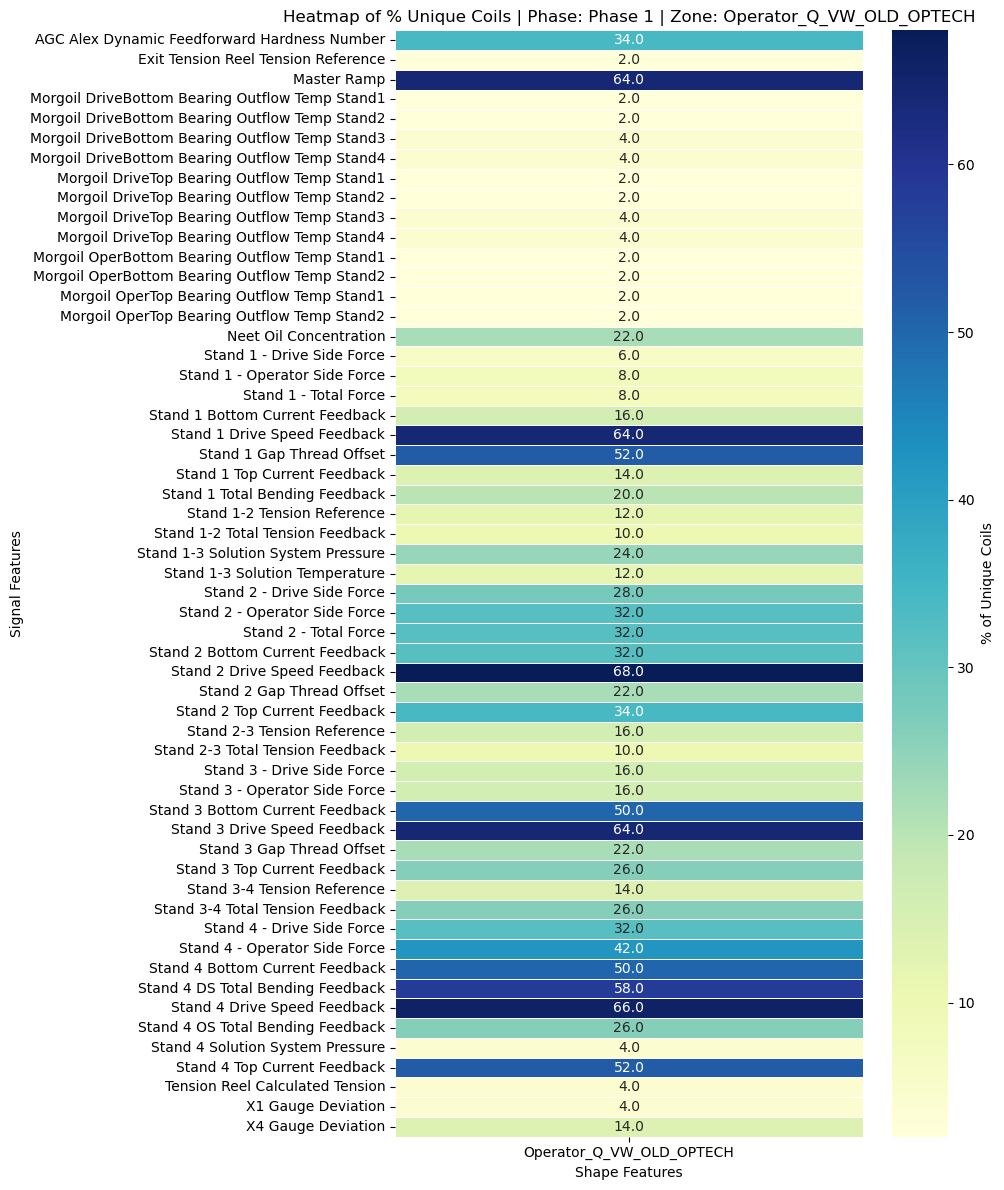

  ↪ Phase Phase 3: 63 coils


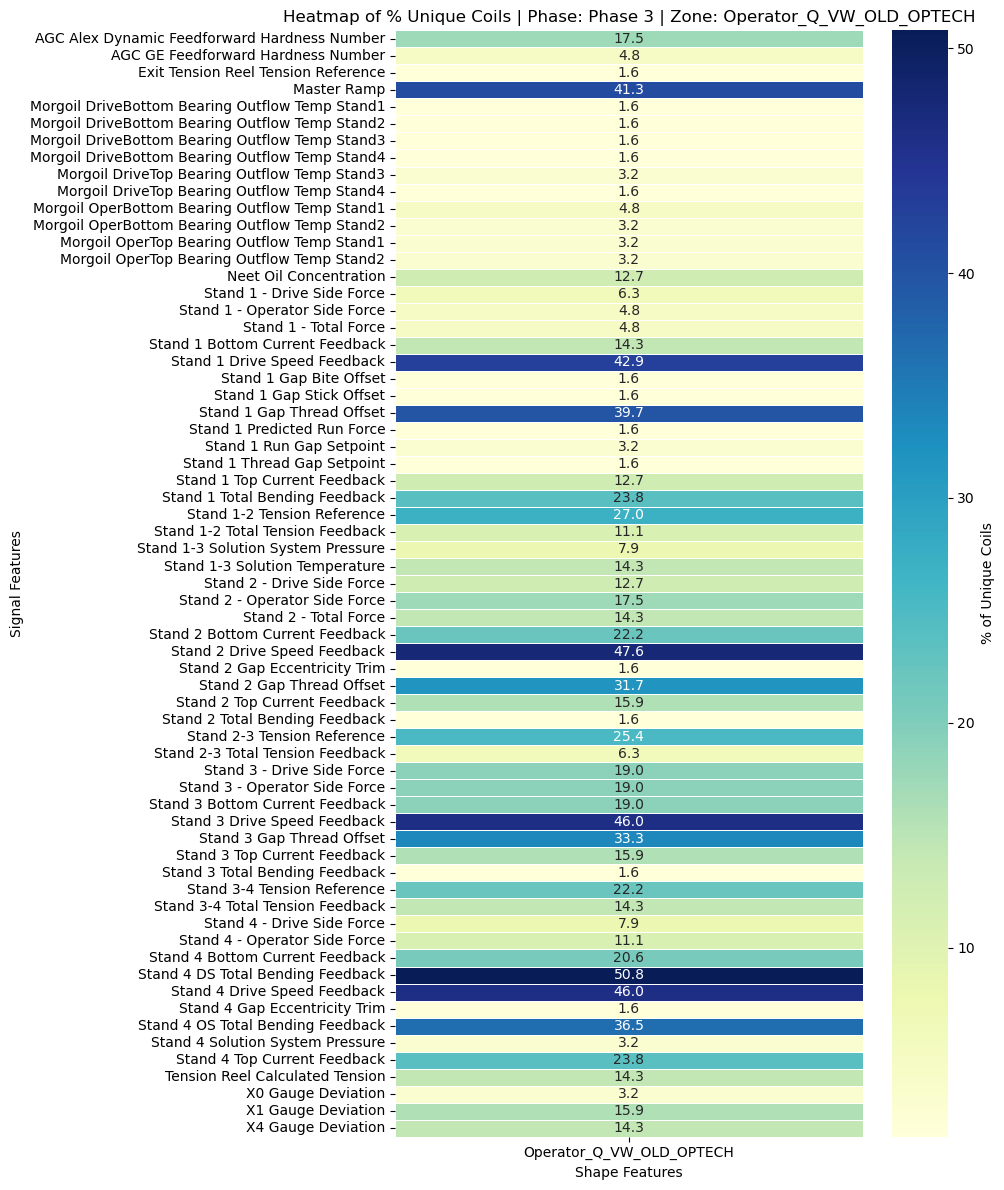

  ↪ Phase Phase 2: 4 coils


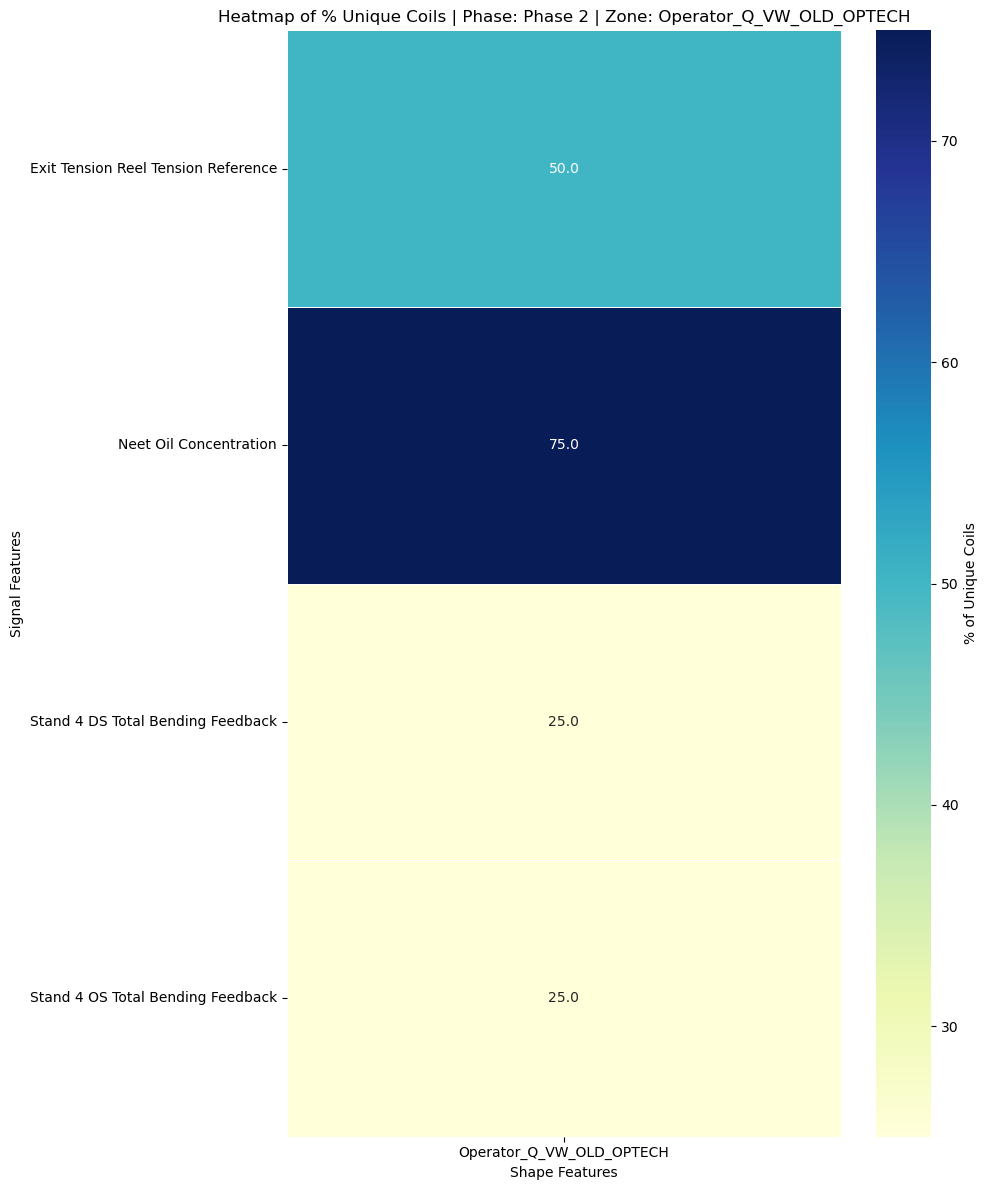


Total coils : 8, Sheet : Q1
  ↪ Phase Phase 1: 4 coils


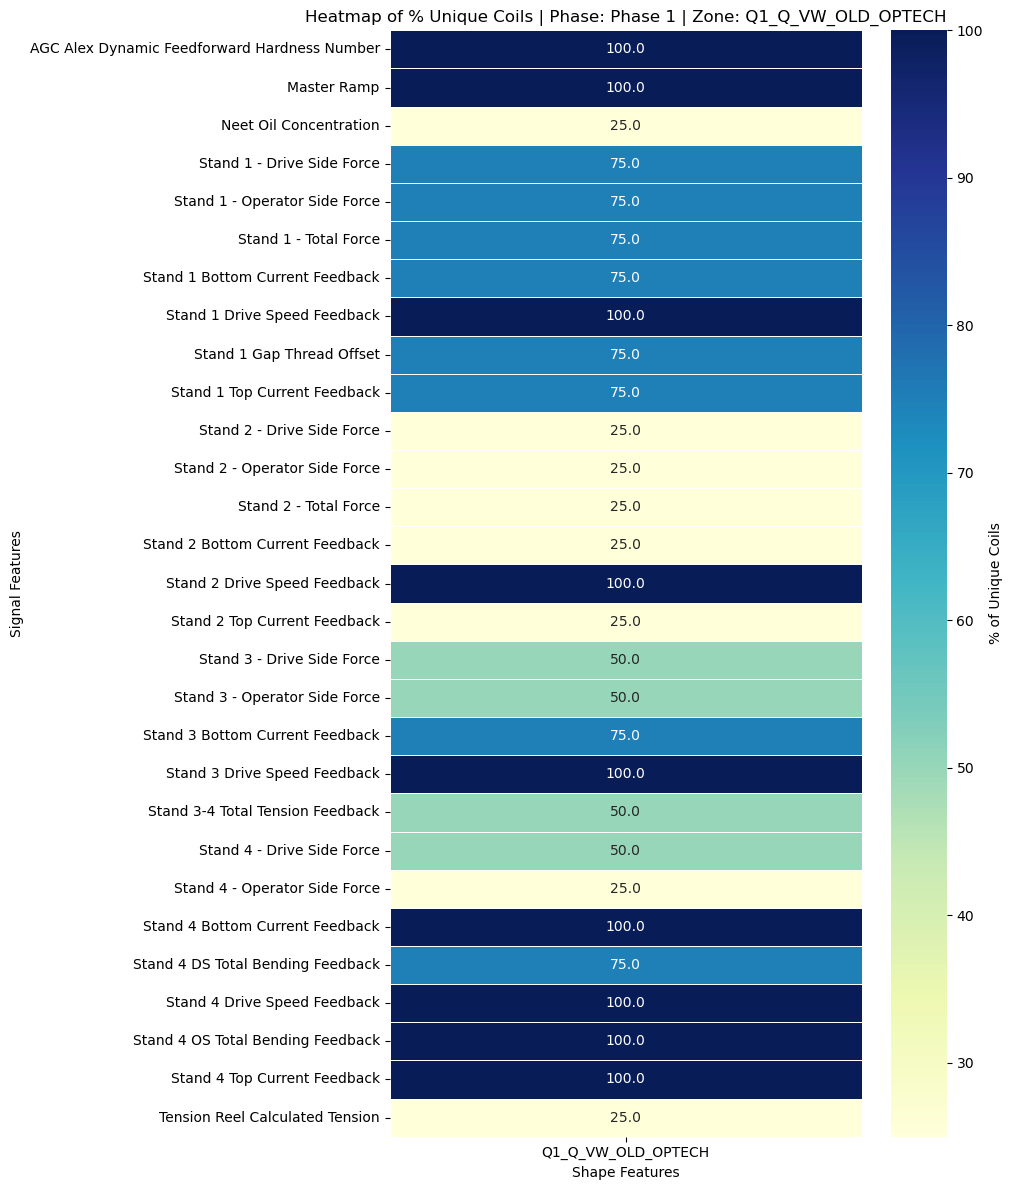

  ↪ Phase Phase 3: 4 coils


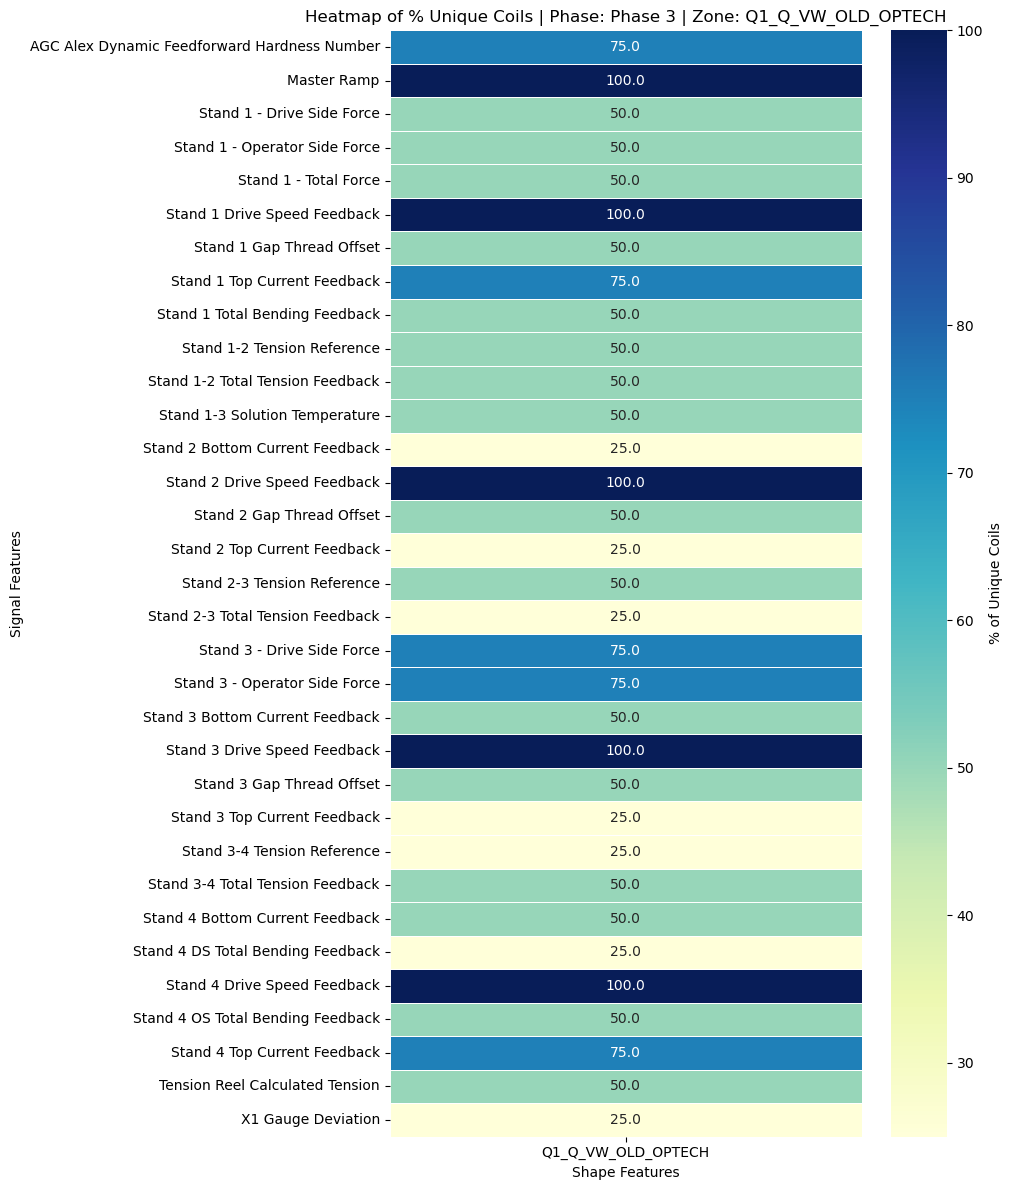

  ↪ Phase Phase 2: 1 coils


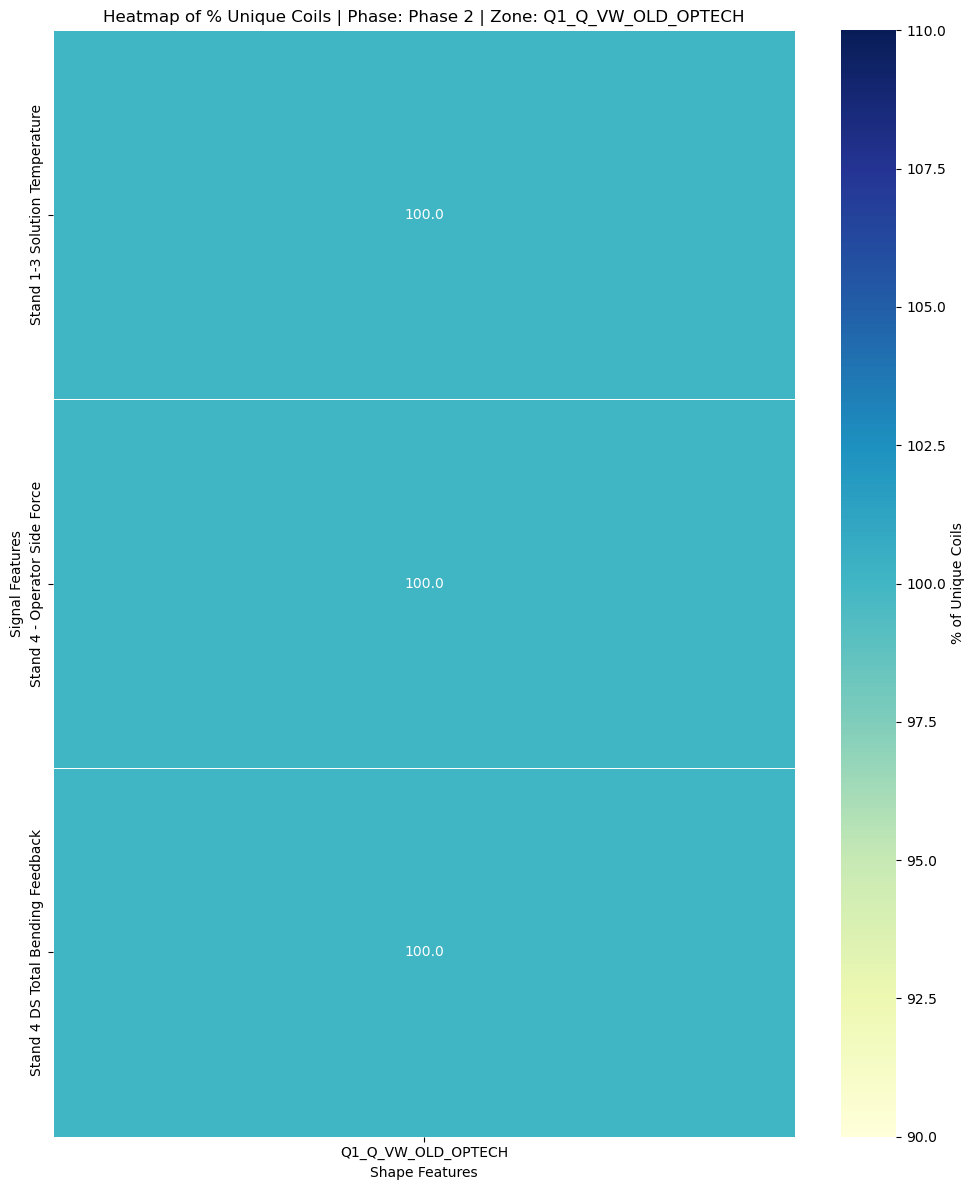


Total coils : 3, Sheet : Center
  ↪ Phase Phase 1: 1 coils


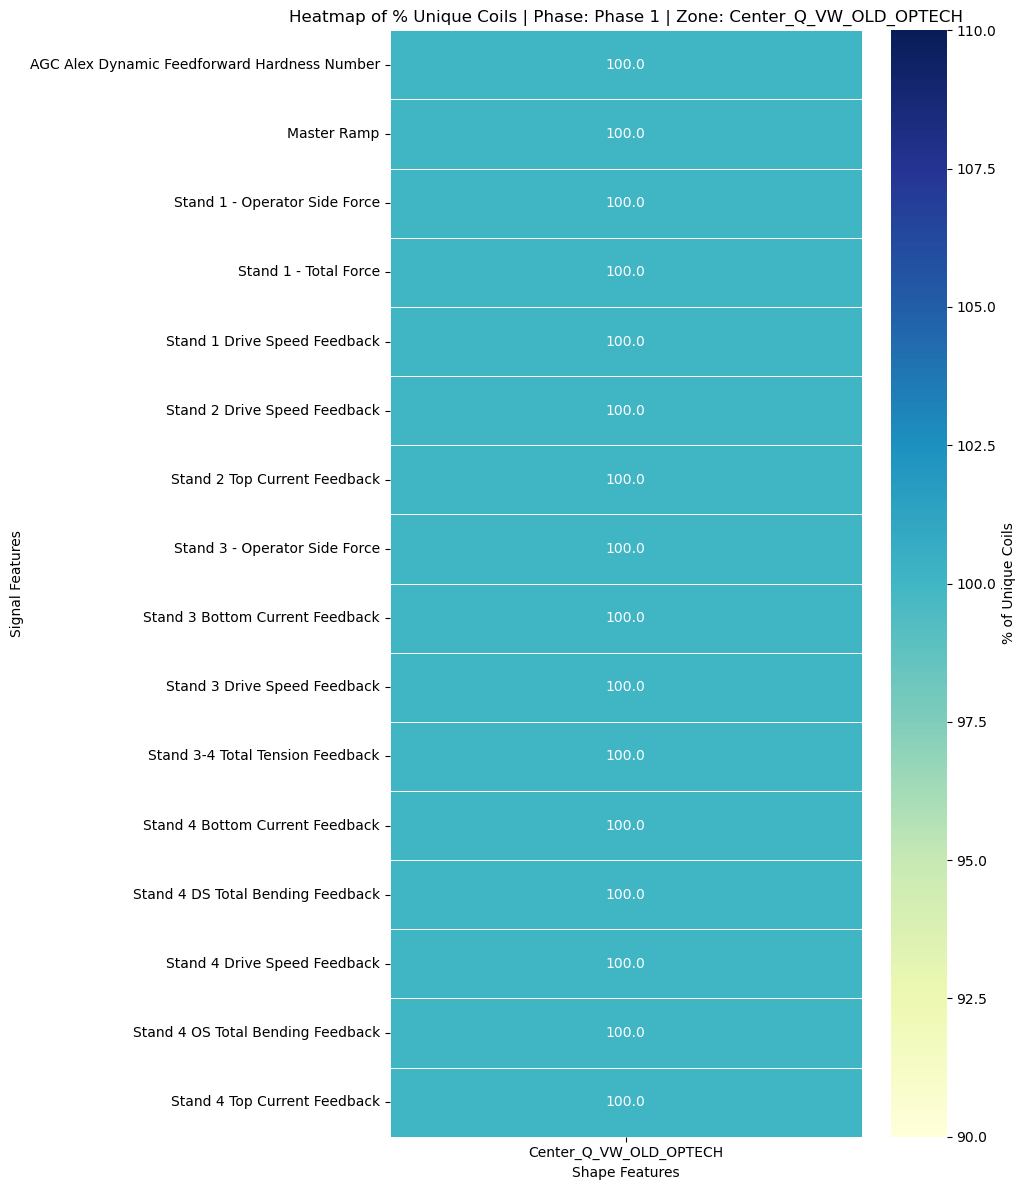

  ↪ Phase Phase 3: 2 coils


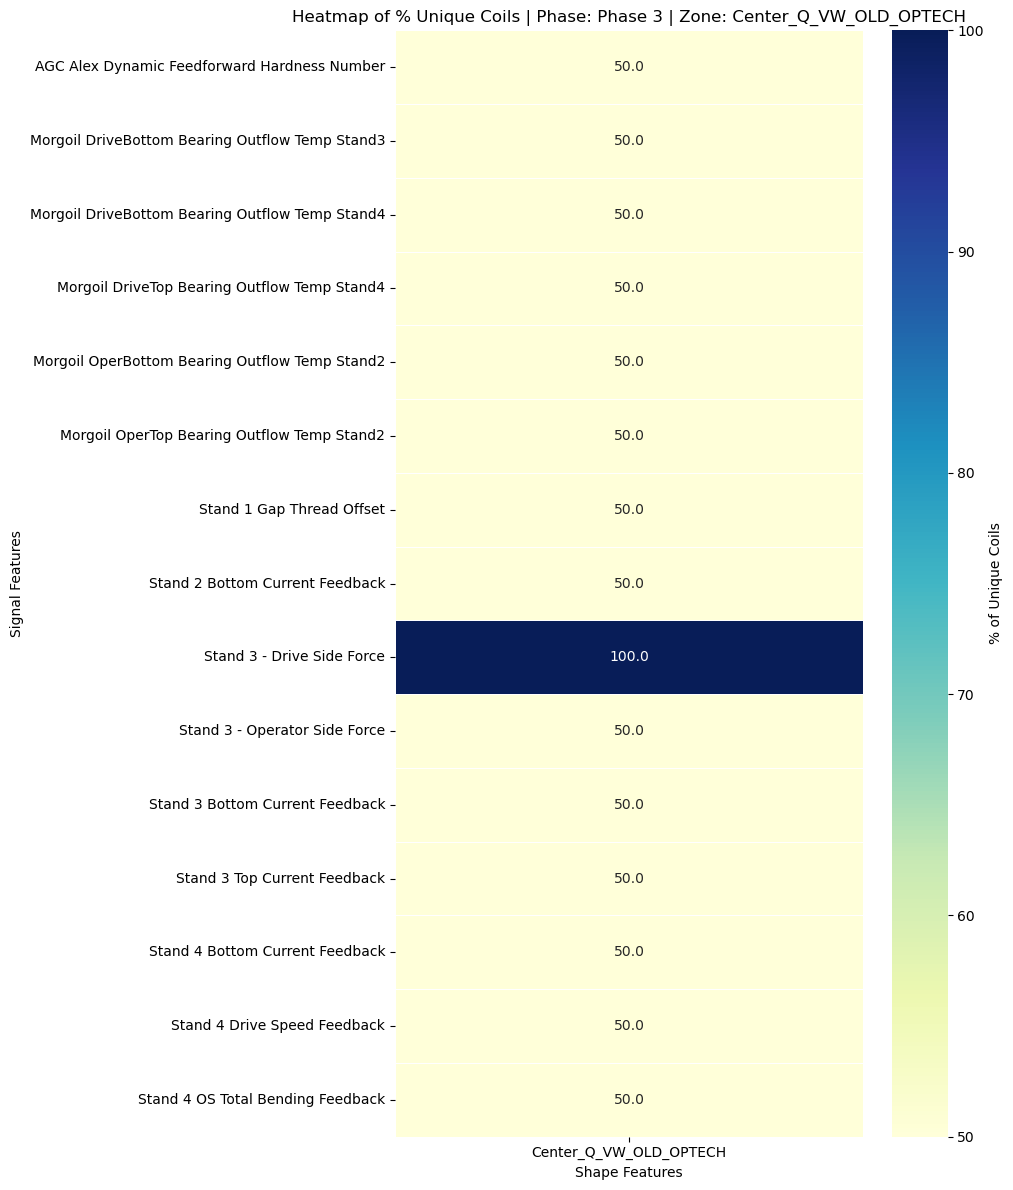

  ↪ Phase Phase 2: 0 coils
⚠️ Skipping phase Phase 2 (no data)

Total coils : 7, Sheet : Q2
  ↪ Phase Phase 1: 1 coils


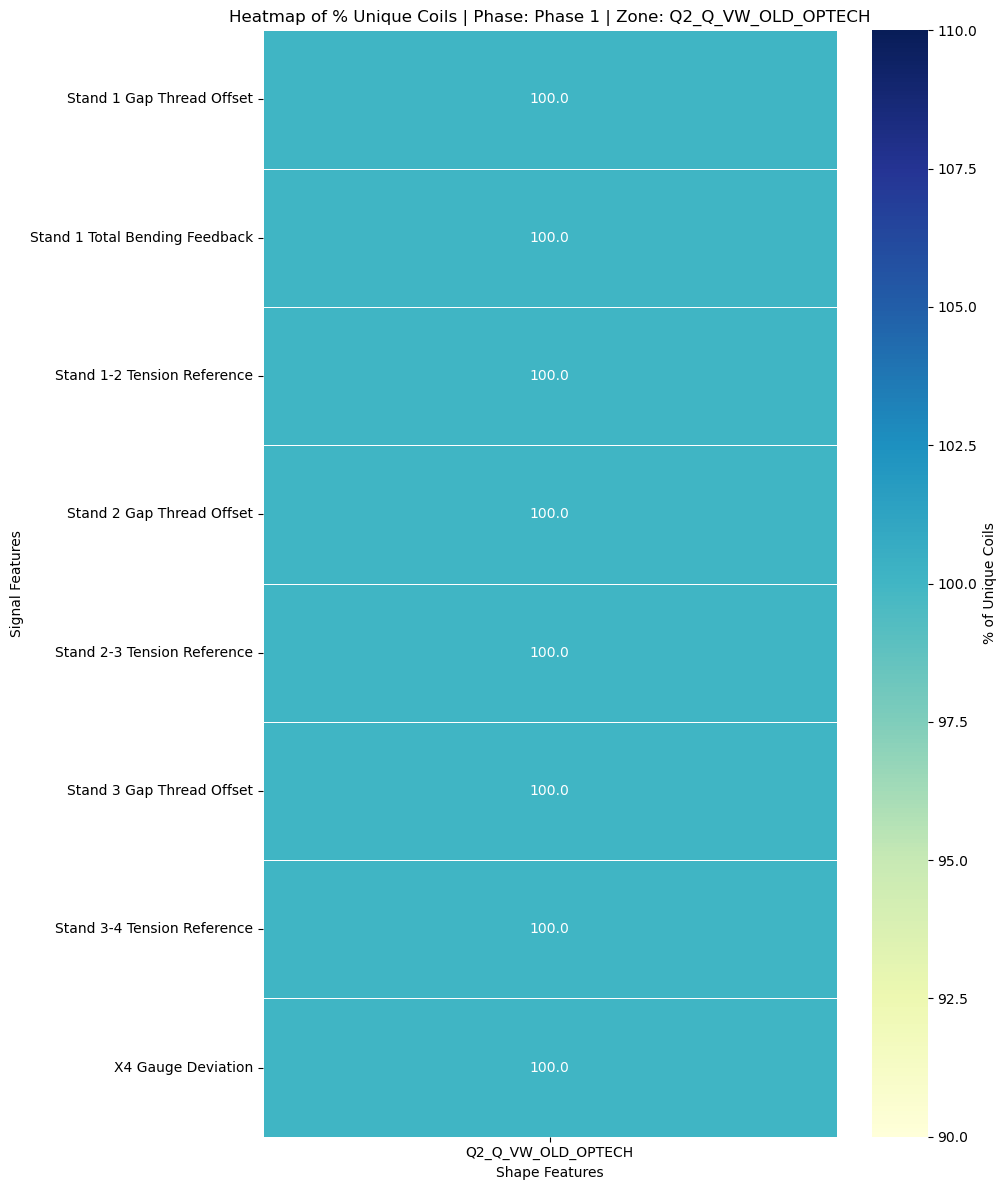

  ↪ Phase Phase 3: 6 coils


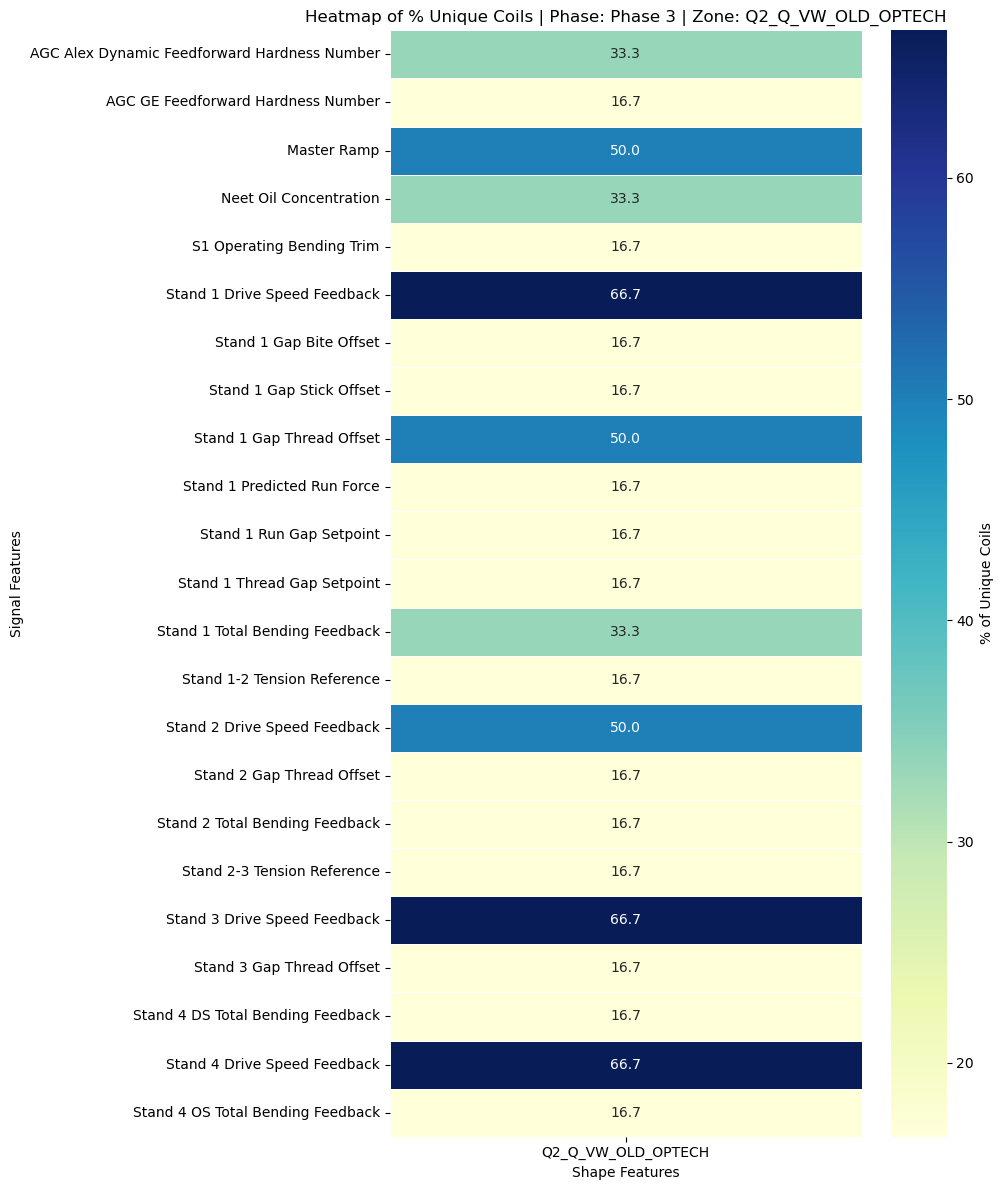

  ↪ Phase Phase 2: 0 coils
⚠️ Skipping phase Phase 2 (no data)

Total coils : 24, Sheet : DRE
  ↪ Phase Phase 1: 9 coils


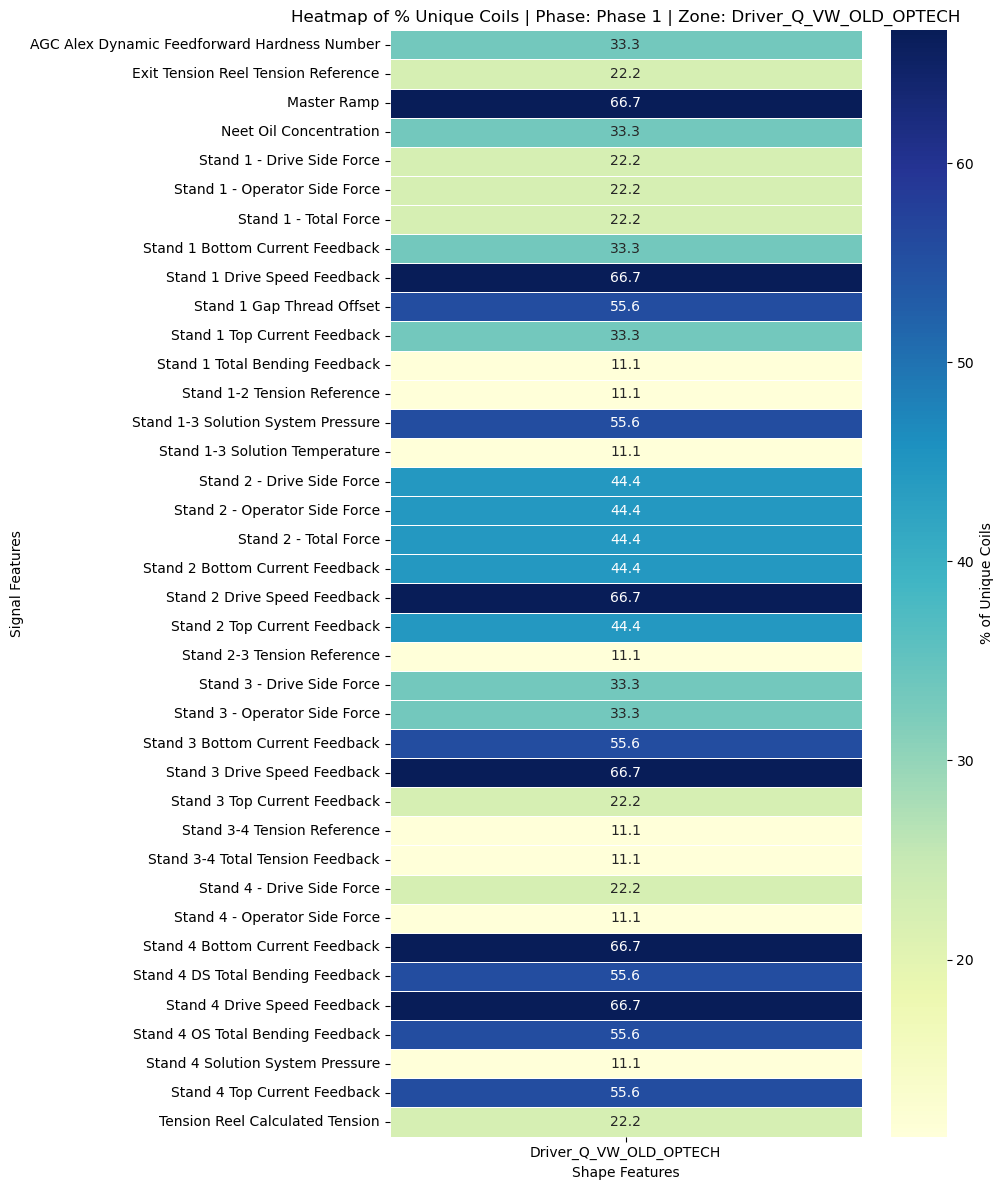

  ↪ Phase Phase 3: 11 coils


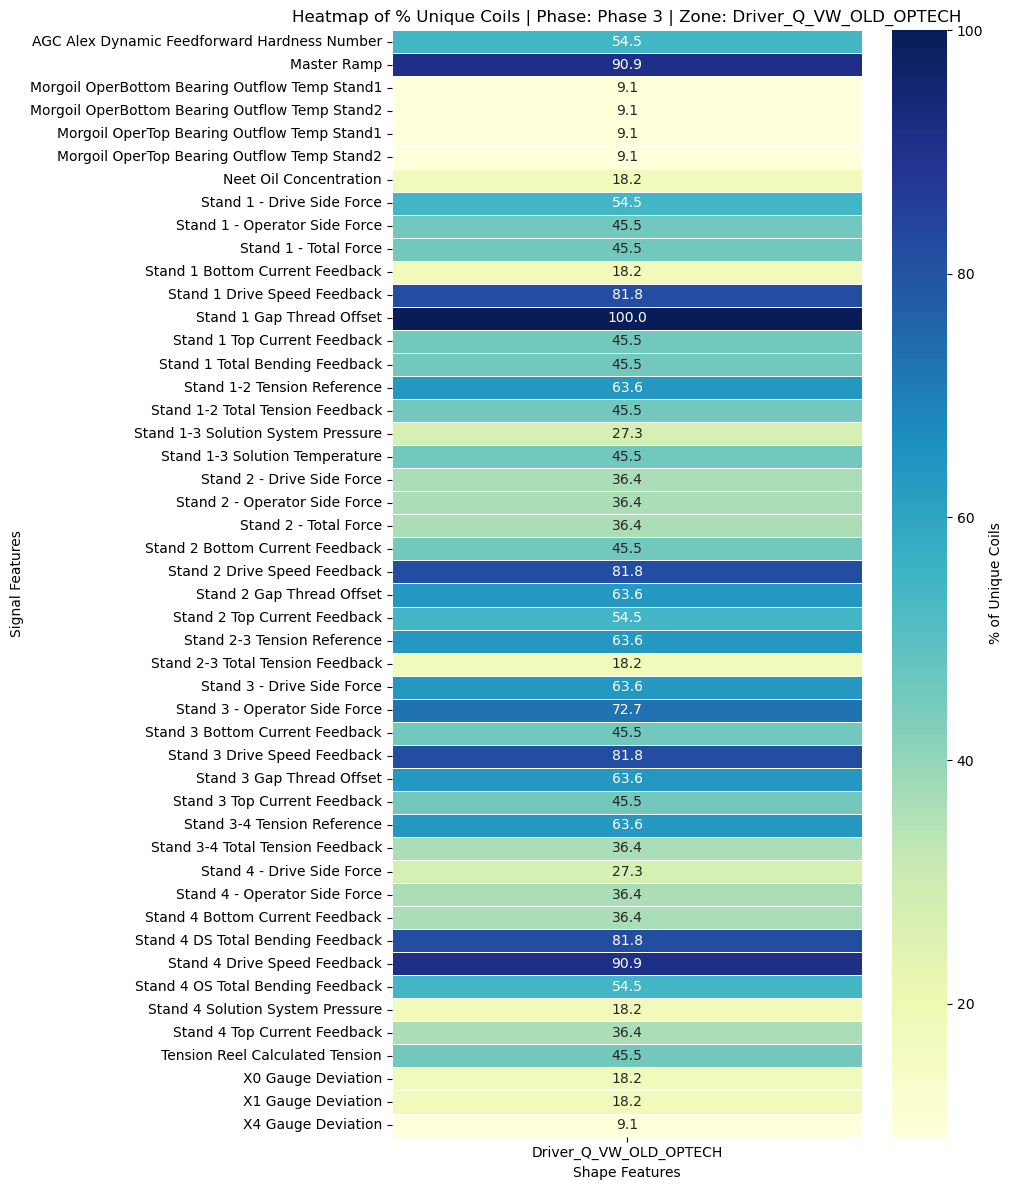

  ↪ Phase Phase 2: 12 coils


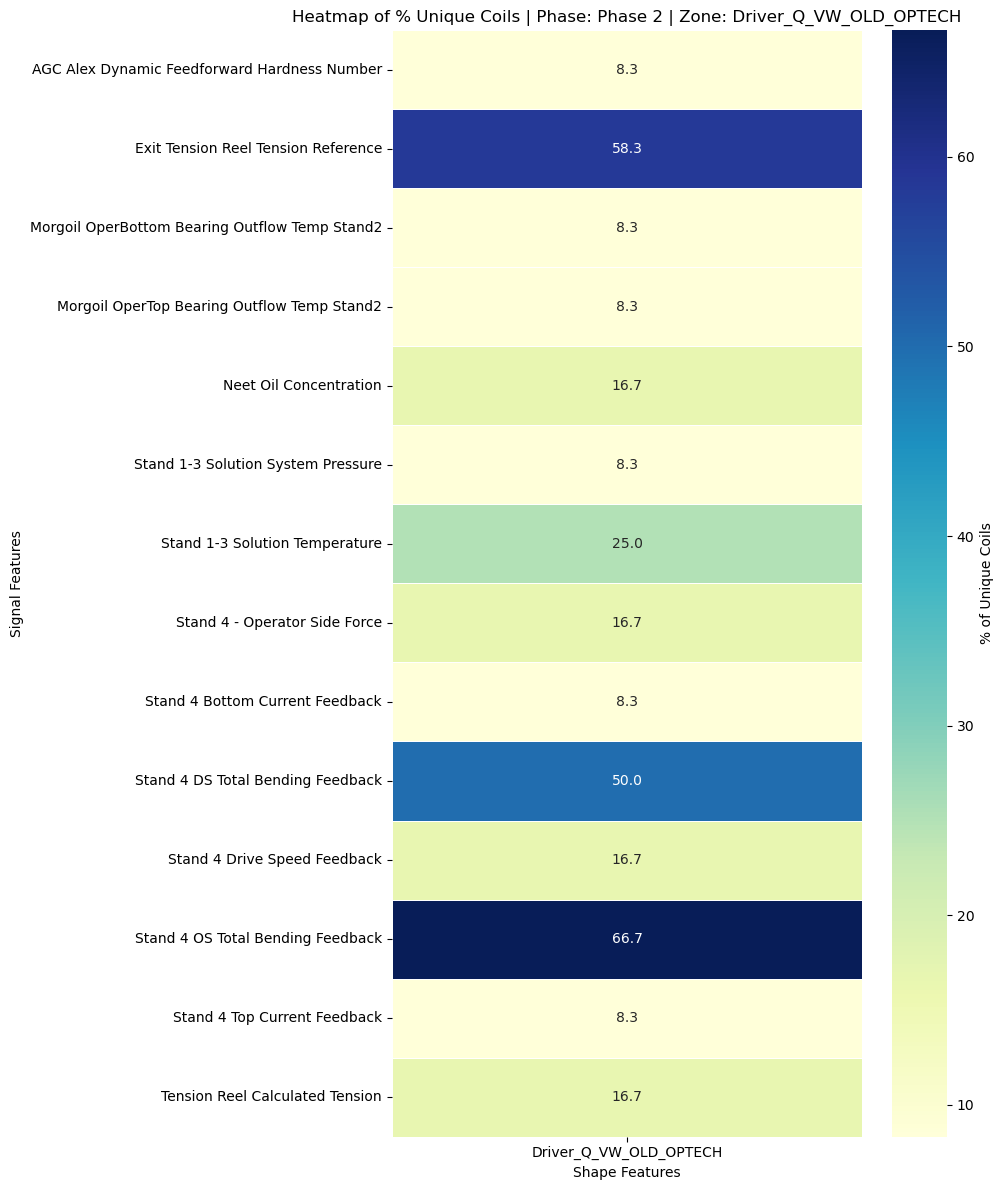

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Shape feature mapping (same as used earlier)
shape_feature_map = {
    'OPE': 'Operator_Q_VW_OLD_OPTECH',
    'Q1': 'Q1_Q_VW_OLD_OPTECH',
    'CENTER': 'Center_Q_VW_OLD_OPTECH',
    'Q2': 'Q2_Q_VW_OLD_OPTECH',
    'DRE': 'Driver_Q_VW_OLD_OPTECH'
}
shape_features = list(shape_feature_map.values())

def generate_heatmap(df, shape_features_to_include=None):
    # Step 1: Count total unique coils
    for sheet in df["Sheet"].unique():
        sheetdf = df[df["Sheet"] == sheet]
        # print(f"{sheetdf.shape}")
        total_unique_coils = sheetdf["Pickle ID"].nunique()
        print(f"\nTotal coils : {total_unique_coils}, Sheet : {sheet}")
        for phase in df["Phase"].unique():
            phase_df = df[(df["Phase"] == phase) & (df["Sheet"] == sheet)]
            unique_coils_in_phase = phase_df['Pickle ID'].nunique()
            print(f"  ↪ Phase {phase}: {unique_coils_in_phase} coils")
    
            if unique_coils_in_phase == 0:
                print(f"⚠️ Skipping phase {phase} (no data)")
                continue
    
            # Step 3: Group by signal-shape and count unique coils
            grouped = phase_df.groupby(['Signal Feature', 'Shape Feature'])['Pickle ID'].nunique().reset_index()
    
            # Step 4: Optional filter by allowed shape features
            if shape_features_to_include:
                grouped = grouped[grouped['Shape Feature'].isin(shape_features_to_include)]
    
            # Step 5: Convert count to %
            grouped['Percentage'] = (grouped['Pickle ID'] / unique_coils_in_phase) * 100
    
            # Step 6: Pivot table for heatmap
            heatmap_data = grouped.pivot(index='Signal Feature', columns='Shape Feature', values='Percentage').fillna(0)
    
            # Step 7: Plot heatmap
            plt.figure(figsize=(10, 12))
            sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5, cbar_kws={'label': '% of Unique Coils'})
            plt.title(f'Heatmap of % Unique Coils | Phase: {phase} | Zone: {grouped['Shape Feature'][0]}')
            plt.xlabel('Shape Features')
            plt.ylabel('Signal Features')
            # plt.xticks(ha='right')
            plt.tight_layout()
            plt.savefig(f"heatmap_percentage_{phase}_{grouped['Shape Feature'][0]}.png", dpi=300)
            plt.show()

# === RUN ===
df = pd.read_csv(r"D:\Stelco\Work\Dynamic Correlation\Key\Phasewise_summary_from_pickle_ids.csv")
generate_heatmap(df,shape_features_to_include=shape_features)

In [11]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt


# def generate_heatmap(df, grade, shape_features_to_include=None):
#     # Step 1: Count total unique coils
#     total_unique_coils = df['Coil ID'].nunique()
#     print(f"Total coils of grade {grade} : {total_unique_coils}")

#     # Step 2: Filter rows with contribution above 5%
#     df = df[df["Contribution Factor %"] > 5]
#     total_unique_coils = df['Coil ID'].nunique()
#     print(f"Total coils of grade {grade} showing contribution above 5% : {total_unique_coils}")

#     for phase in df["Phase"].unique():
#         phase_df = df[df["Phase"] == phase]
#         total_unique_coils = phase_df['Coil ID'].nunique()
#         print(f"Total coils of grade {grade} showing contribution above 5% in {phase} : {total_unique_coils}")
    
#         # Step 3: Count unique Coil IDs for each Signal-Shape pair
#         grouped = phase_df.groupby(['Signal Feature', 'Shape Feature'])['Coil ID'].nunique().reset_index()

#         # Optional: filter to include only selected Shape Features
#         if shape_features_to_include:
#             grouped = grouped[grouped['Shape Feature'].isin(shape_features_to_include)]
        
#         # Step 4: Calculate percentage
#         grouped['Percentage'] = (grouped['Coil ID'] / total_unique_coils) * 100
        
#         # Step 5: Pivot for heatmap
#         heatmap_data = grouped.pivot(index='Signal Feature', columns='Shape Feature', values='Percentage').fillna(0)
        
#         plt.figure(figsize=(11, 8))
#         sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': '% of Unique Coils'})
#         plt.title(f'Heatmap of % Unique Coils per Signal-Shape Feature Combination | {phase} | {grade}')
#         plt.xlabel('Shape Features')
#         plt.ylabel('Signal Features')
#         plt.tight_layout()
#         plt.savefig(f"heatmap_percentage_{phase}.png", dpi=300)
#         plt.show()

In [ ]:
# df = pd.read_csv(r"D:\Stelco\Work\Dynamic Correlation\Key\Phasewise_summary_from_pickle_ids.csv")
# generate_heatmap(df, "1008GCQ",shape_features)

(118,)
(6163,)
(1348,)


Phase  Total Windows  Significant Windows  Contribution Factor (%)
0  Phase 1              0                    0                   0.0000
1  Phase 2           5914                    0                   0.0000
2  Phase 3            562                   70                  12.4555

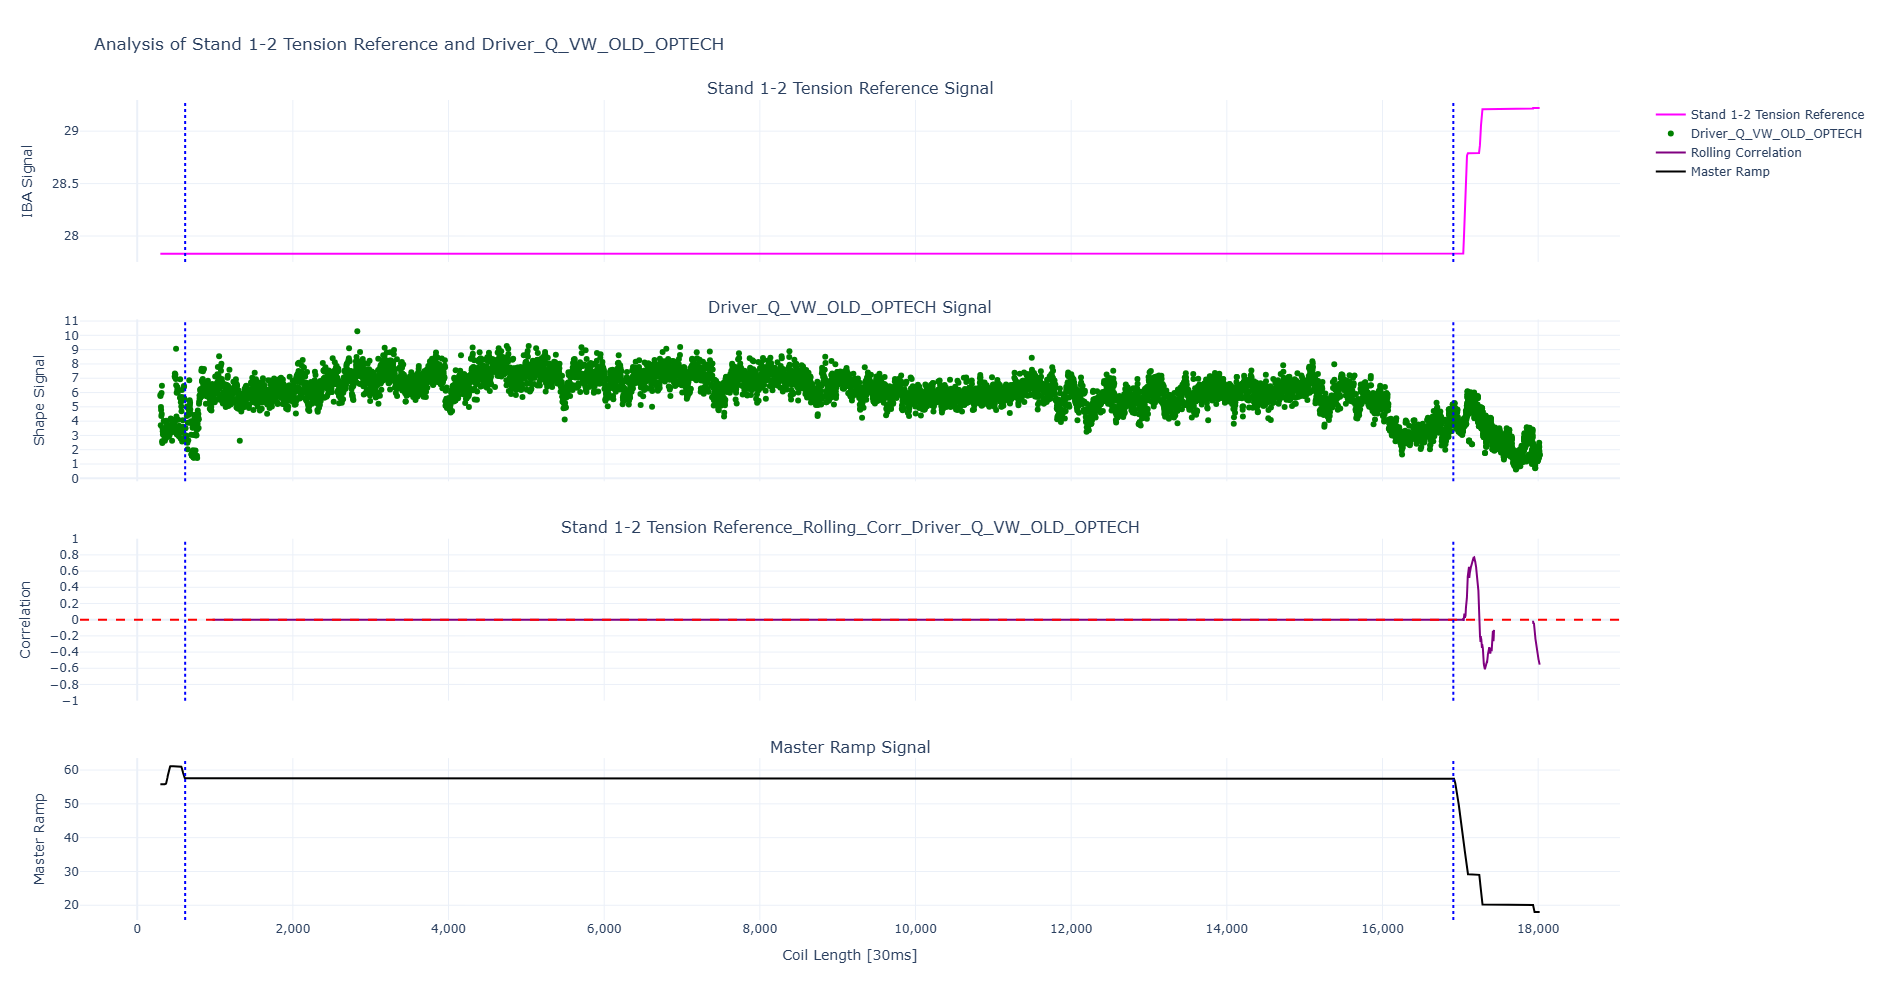

In [20]:
def plot_master_ramp(csv_file_path, ramp_col='Master Ramp'):
    try:
        # Read the CSV file
        df = pd.read_csv(csv_file_path, low_memory=False)

        # Get the start and end indices based on 'Coil Length [30ms]'
        start_time_index = df[df['Coil Length [30ms]'] == 0].index[-1]
        df_from_start = df.loc[start_time_index:]
        end_time_index = df_from_start['Coil Length [30ms]'].idxmax()
        df = df[start_time_index:end_time_index].reset_index(drop=True)

        # Check if the maximum value in 'Master Ramp' is less than or equal to 15
        master_ramp = df[ramp_col]
        if master_ramp.max() <= 15:
            print('Low Master Ramp')
            return

        # Get the most frequently occurring value in the specified column
        normalisation_value = df[ramp_col].mode()[0]

        # Filter the DataFrame to only include rows with the normalization value
        normalisation_df = df[df[ramp_col] == normalisation_value]

        # Get the indices for the first and last occurrences of the normalization value
        first_phase_end_index = normalisation_df.index[0]
        second_phase_end_index = normalisation_df.index[-1]

        # Define the phases of the process
        first_phase_df = df.loc[:first_phase_end_index]
        second_phase_df = df.loc[first_phase_end_index:second_phase_end_index]
        third_phase_df = df.loc[second_phase_end_index + 1:]

        # Indices where vertical lines should be drawn
        index_1 = first_phase_end_index
        index_2 = second_phase_end_index

        # Create figure
        fig = go.Figure()

        # Add "Master Ramp" data to the plot
        fig.add_trace(go.Scatter(y=df[ramp_col], mode='lines', name=ramp_col))

        # Add vertical lines at specified indices
        fig.add_vline(x=index_1, line=dict(color='red', width=2))
        fig.add_vline(x=index_2, line=dict(color='red', width=2))

        # Update layout
        fig.update_layout(title=ramp_col,
                          xaxis_title='Index',
                          yaxis_title=ramp_col)

        # Show plot
        fig.show()

    except Exception as e:
        print(f'Error: {e}')

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def analyze_and_plot_phases(
    df, continuous_col, discrete_col, corr_col, coil_length_col, ramp_col="Master Ramp", correlation_threshold=0.7
):
    # Extract coil length
    coil_length_values = df[coil_length_col]

    if df[ramp_col].max() <= 15:
        print("Low Master Ramp")
        return

    norm_val = df[ramp_col].mode()[0]
    norm_df = df[df[ramp_col] == norm_val]
    phase1_end = norm_df.index[0]
    phase2_end = norm_df.index[-1]

    phase1_df = df.iloc[:phase1_end+1]
    phase2_df = df.iloc[phase1_end:phase2_end+1]
    phase3_df = df.iloc[phase2_end+1:]

    window_size = 250

    def get_correlation_stats(phase_df):
        print(phase_df[corr_col].shape)
        corr_series = phase_df[corr_col].iloc[window_size-1:].dropna()
        total = len(corr_series)
        significant = (corr_series.abs() >= correlation_threshold).sum()
        return total, significant

    phase1_total, phase1_significant = get_correlation_stats(phase1_df)
    phase2_total, phase2_significant = get_correlation_stats(phase2_df)
    phase3_total, phase3_significant = get_correlation_stats(phase3_df)

    
    # print(f"Phase 1: Total Windows = {phase1_total}, Significant = {phase1_significant}")
    # print(f"Phase 2: Total Windows = {phase2_total}, Significant = {phase2_significant}")
    # print(f"Phase 3: Total Windows = {phase3_total}, Significant = {phase3_significant}")

    window_data = {
        "Phase": ["Phase 1", "Phase 2", "Phase 3"],
        "Total Windows": [phase1_total, phase2_total, phase3_total],
        "Significant Windows": [phase1_significant, phase2_significant, phase3_significant],
        "Contribution Factor (%)": [
            round((phase1_significant / phase1_total) * 100, 4) if phase1_total != 0 else 0,
            round((phase2_significant / phase2_total) * 100, 4) if phase2_total != 0 else 0,
            round((phase3_significant / phase3_total) * 100, 4) if phase3_total != 0 else 0
        ]
    }

    window_data_df = pd.DataFrame(window_data)
    display(window_data_df)

    # --- Plotting ---
    fig = make_subplots(
        rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.07,
        subplot_titles=[
            f"{continuous_col} Signal",
            f"{discrete_col} Signal",
            f"{corr_col}",
            f"{ramp_col} Signal"
        ]
    )

    fig.add_trace(go.Scatter(x=coil_length_values, y=df[continuous_col], mode="lines", name=continuous_col,
                             line=dict(color="magenta")), row=1, col=1)
    fig.add_trace(go.Scatter(x=coil_length_values, y=df[discrete_col], mode="markers", name=discrete_col,
                             marker=dict(color="green", size=6)), row=2, col=1)
    fig.add_trace(go.Scatter(x=coil_length_values, y=df[corr_col], mode="lines", name="Rolling Correlation",
                             line=dict(color="purple")), row=3, col=1)
    fig.add_trace(go.Scatter(x=coil_length_values, y=df[ramp_col], mode="lines", name=ramp_col,
                             line=dict(color="black")), row=4, col=1)

    fig.add_hline(y=0, line=dict(color="red", dash="dash"), row=3, col=1)

    # Add vertical lines for Phase 2 start and end
    x1 = df[coil_length_col].iloc[phase1_end]
    x2 = df[coil_length_col].iloc[phase2_end]
    for row in [1, 2, 3, 4]:
        fig.add_vline(x=x1, line=dict(color="blue", dash="dot"), row=row, col=1)
        fig.add_vline(x=x2, line=dict(color="blue", dash="dot"), row=row, col=1)

    fig.update_yaxes(title_text="IBA Signal", row=1, col=1)
    fig.update_yaxes(title_text="Shape Signal", dtick=1, row=2, col=1)
    fig.update_yaxes(title_text="Correlation", range=[-1, 1], dtick=0.2, row=3, col=1)
    fig.update_yaxes(title_text="Master Ramp", row=4, col=1)

    fig.update_xaxes(tickformat=",.0f", row=4, col=1)
    fig.update_layout(
        title_text=f"Analysis of {continuous_col} and {discrete_col}",
        height=1000,
        xaxis4=dict(title=coil_length_col),
        template="plotly_white",
        showlegend=True
    )

    fig.show()

# Example usage
df = pd.read_csv(r"D:\Stelco\Work\Dynamic Correlation\Key\Master whole Phase\5508420.csv")
analyze_and_plot_phases(
    df,
    # continuous_col="Stand 4 Drive Speed Feedback",
    continuous_col="Stand 1-2 Tension Reference",
    
    # discrete_col="Driver_Q_VW",
    discrete_col="Driver_Q_VW_OLD_OPTECH",
    
    corr_col="Stand 1-2 Tension Reference_Rolling_Corr_Driver_Q_VW_OLD_OPTECH",
    coil_length_col="Coil Length [30ms]",
    ramp_col="Master Ramp"
)